In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.vis_model import *
from src.models.train_model import *

Using TensorFlow backend.


Loading BokehJS ...

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Optimize for Normal

In [38]:
print('====== NN op1 load RF model ====== ')
data, model, fire_cols = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7, 0.3])

data no fire has shape (77747, 14)

 fire_columns ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols_org ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_W', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000', 'Temperature(C)_lag_1', 'Humidity(%)_lag_1', 'Wind Speed(kmph)_lag_1', 'wind_N_lag_1', 'wind_W_lag_1', 'is_holiday_lag_1', 'is_weekend_lag_1', 'day_of_week_lag_1', 'time_of_day_lag_1', 'fire_100_200_lag_1', 'fire_200_400_lag_1', 'fire_400_700_lag_1', 'fire_700_1000_lag_1']
model performance {'test_r2_score': 0.6641845910943396, 'test_mean_squared_error': 262.54691473209186, 'test_mean_a

In [39]:
data.x_cols = data.data.columns.drop(data.monitor)
data.x_cols

Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_N', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200',
       'fire_200_400', 'fire_400_700', 'fire_700_1000', 'Temperature(C)_lag_1',
       'Humidity(%)_lag_1', 'Wind Speed(kmph)_lag_1', 'wind_CALM_lag_1',
       'wind_N_lag_1', 'wind_W_lag_1', 'is_rain_lag_1', 'is_holiday_lag_1',
       'is_weekend_lag_1', 'day_of_week_lag_1', 'time_of_day_lag_1',
       'fire_0_100_lag_1', 'fire_100_200_lag_1', 'fire_200_400_lag_1',
       'fire_400_700_lag_1', 'fire_700_1000_lag_1'],
      dtype='object')

In [40]:
data.split_data(split_ratio=[0.45, 0.25, 0.3])
xtrn, ytrn, data.x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
ytrn = ytrn.reshape(-1,1)

xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)
yval = yval.reshape(-1,1)

xtest, ytest, _ = data.get_data_matrix(use_index=data.split_list[2], x_cols=data.x_cols)
ytest = ytest.reshape(-1,1)
 
min_max_scaler = MinMaxScaler()
xtrn = min_max_scaler.fit_transform(xtrn)
xval = min_max_scaler.transform(xval)
xtest = min_max_scaler.transform(xtest)

min_max_scaler_y = MinMaxScaler()
ytrn = min_max_scaler_y.fit_transform(ytrn)
yval = min_max_scaler_y.transform(yval)
ytest = min_max_scaler_y.transform(ytest)

In [8]:
# nn search parameters
num_layers = Integer(low=1, high=5, name='num_layer')
nn_sizes = Integer(low=8, high=1024, name='nn_size')
act_funs = Categorical(categories=['relu','softplus'],
                             name='act_fun')
drops = Real(low=0, high=0.2,
                         name='drop')
lrs = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='lr')
momentums = Real(low=0.7, high=0.99, 
                         name='momentum')
dimensions = [num_layers,nn_sizes,act_funs,drops,lrs,momentums]
default_params = [2,954,'softplus',0.05,2E-3,0.79]

In [9]:
model = get_model(input_shape=xtrn.shape[1],output_shape=ytrn.shape[1],num_layer=2,nn_size=954,act_fun='softplus',drop=0.06,lr= 0.002,momentum=0.8)
esm = EarlyStopping(patience=8,verbose=0,restore_best_weights=True)
history = model.fit(xtrn, ytrn,validation_split=0.2,verbose=1,epochs=1000,callbacks=[esm])
   
y_pred = model.predict(xval)
cal_scores(yval,y_pred)

Train on 27988 samples, validate on 6997 samples
Epoch 1/1000
27988/27988 [==============================] - 7s 246us/step - loss: 0.6403 - val_loss: 0.0203
Epoch 2/1000
27988/27988 [==============================] - 15s 551us/step - loss: 0.0434 - val_loss: 0.0147
Epoch 3/1000
27988/27988 [==============================] - 21s 764us/step - loss: 0.0179 - val_loss: 0.0183
Epoch 4/1000
27988/27988 [==============================] - 21s 751us/step - loss: 0.0087 - val_loss: 0.0138
Epoch 5/1000
27988/27988 [==============================] - 22s 778us/step - loss: 0.0067 - val_loss: 0.0144
Epoch 6/1000
27988/27988 [==============================] - 21s 758us/step - loss: 0.0072 - val_loss: 0.0144
Epoch 7/1000
27988/27988 [==============================] - 22s 778us/step - loss: 0.0074 - val_loss: 0.0143
Epoch 8/1000
27988/27988 [==============================] - 21s 757us/step - loss: 0.0079 - val_loss: 0.0135
Epoch 9/1000
27988/27988 [==============================] - 22s 770us/step - los

0.573233253826007

In [21]:
cal_scores(min_max_scaler_y.inverse_transform(ytest), min_max_scaler_y.inverse_transform(model.predict(xtest)))

{'test_r2_score': 0.5592786304770223,
 'test_mean_squared_error': 344.5588194369468,
 'test_mean_absolute_error': 11.411611048529089}

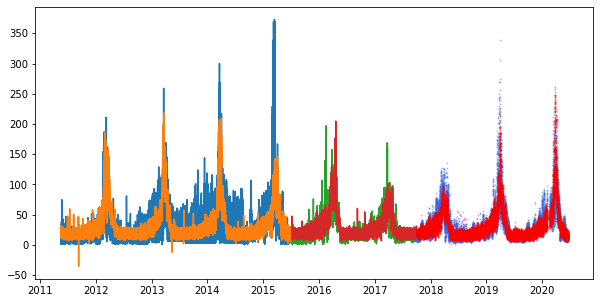

In [27]:
plt.figure(figsize=(10,5))
plt.plot(data.split_list[0], min_max_scaler_y.inverse_transform(ytrn))
plt.plot(data.split_list[0], min_max_scaler_y.inverse_transform(model.predict(xtrn)))
plt.plot(data.split_list[1], min_max_scaler_y.inverse_transform(yval))
plt.plot(data.split_list[1], min_max_scaler_y.inverse_transform(y_pred))

plt.plot(data.split_list[2], min_max_scaler_y.inverse_transform(ytest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='royalblue')
plt.plot(data.split_list[2], min_max_scaler_y.inverse_transform(model.predict(xtest)), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')

In [44]:
@use_named_args(dimensions)
def fit_with(num_layer, nn_size, act_fun, drop, lr, momentum):
    # function to return the score (smaller better)
    model = get_model(input_shape=xtrn.shape[1], output_shape=ytrn.shape[1], num_layer=num_layer,
                      nn_size=nn_size, act_fun=act_fun, drop=drop, lr=lr, momentum=momentum)
    # set early stoping
    esm = EarlyStopping(patience=8, verbose=0, restore_best_weights=True)
    # train model
    history = model.fit(xtrn, ytrn, validation_split=0.2,
                        verbose=0, epochs=200, callbacks=[esm])

    y_pred = model.predict(xval)
    K.clear_session()

    return mean_squared_error(yval, y_pred)


gp_result = gp_minimize(
    func=fit_with, dimensions=dimensions, n_jobs=-1, random_state=30)

print(gp_result.x)
score = gp_result.fun
print(score)

[2, 954, 'softplus', 0.05515478204430233, 0.0028930272228813387, 0.788741976516741]


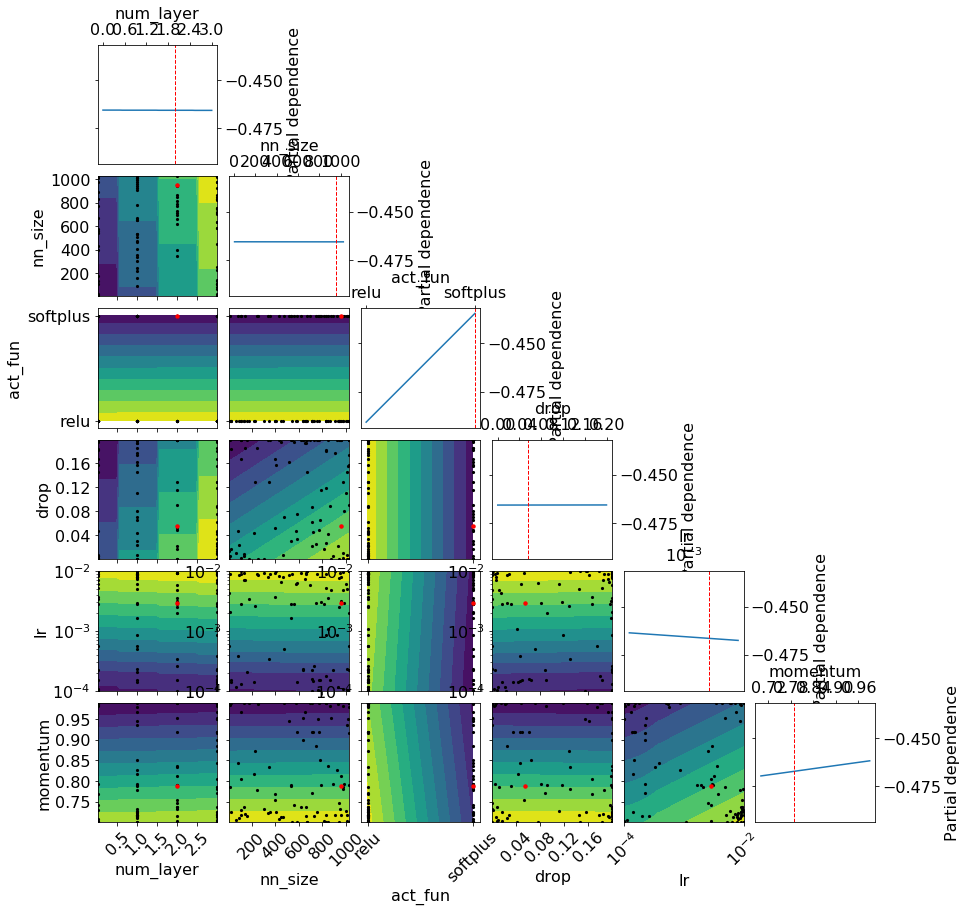

In [48]:
_ = plot_objective(gp_result)

# Traing s2 function

In [2]:
%%time
nn_dict, model, x_scaler, y_scaler = train_city_s2(city='Chiang Mai', pollutant='PM2.5', build=False)

====== NN op1 load RF model ====== 
data no fire has shape (77747, 14)

 fire_columns ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols_org ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000', 'Temperature(C)_lag_1', 'Humidity(%)_lag_1', 'Wind Speed(kmph)_lag_1', 'wind_CALM_lag_1', 'wind_E_lag_1', 'wind_N_lag_1', 'wind_S_lag_1', 'is_rain_lag_1', 'is_holiday_lag_1', 'is_weekend_lag_1', 'day_of_week_lag_1', 'time_of_day_lag_1', 'fire_0_100_lag_1', 'fire_100_200_lag_1', 'fire_200_400_lag_1', 'fire_400_7

## Try Dropping Columns

In [18]:
data, model, fire_cols = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.45, 0.25, 0.3])

data no fire has shape (77747, 14)

 fire_columns ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols_org ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000', 'Temperature(C)_lag_1', 'Humidity(%)_lag_1', 'Wind Speed(kmph)_lag_1', 'wind_CALM_lag_1', 'wind_E_lag_1', 'wind_N_lag_1', 'wind_S_lag_1', 'is_rain_lag_1', 'is_holiday_lag_1', 'is_weekend_lag_1', 'day_of_week_lag_1', 'time_of_day_lag_1', 'fire_0_100_lag_1', 'fire_100_200_lag_1', 'fire_200_400_lag_1', 'fire_400_700_lag_1', 'fire_700_1000_lag_1', 'T

In [19]:
data.x_cols = data.data.columns.drop(data.monitor)
data.split_data(split_ratio=[0.45, 0.25, 0.3])

xtrn, ytrn, data.x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
ytrn = ytrn.reshape(-1,1)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)
yval = yval.reshape(-1,1)

xtrn = x_scaler.fit_transform(xtrn)
xval = x_scaler.transform(xval)
ytrn = y_scaler.fit_transform(ytrn)

In [22]:
nn_dict = {'num_layer': 1, 'nn_size': 72, 'act_fun': 'softplus',
           'drop': 0.2, 'lr': 0.01, 'momentum': 0.99}
model = get_nn_model(input_shape=xtrn.shape[1], output_shape=ytrn.shape[1],
                     num_layer=nn_dict['num_layer'], nn_size=nn_dict['nn_size'], act_fun=nn_dict['act_fun'], drop=nn_dict['drop'], lr=nn_dict['lr'], momentum=nn_dict['momentum'])
esm = EarlyStopping(patience=8, verbose=0, restore_best_weights=True)
history = model.fit(xtrn, ytrn, validation_split=0.2,
                    verbose=0, epochs=1000, callbacks=[esm])

In [ ]:
feat_imp = feat_importance(model, xtrn, ytrn, data.x_cols, score=r2_score, n_iter=20)

In [ ]:
# optimize 1 drop unuse cols 
to_drop = feat_imp['index'].to_list()
no_drop = ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']  + [a for a in data.x_cols_org if 'fire' in a]
for s in no_drop:
    to_drop.remove(s)
to_drop.reverse()


In [ ]:
x_cols = data.x_cols

for col in tqdm_notebook(to_drop):
        
    xtrn, ytrn, x_cols = dataset.get_data_matrix(use_index=trn_index,x_cols=x_cols)
    xval, yval, _ = dataset.get_data_matrix(use_index=val_index,x_cols=x_cols)
    xtrn, ytrn, data.x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
    
    ytrn = ytrn.reshape(-1,1)
    yval = yval.reshape(-1,1)

    xtrn = x_scaler.fit_transform(xtrn)
    xval = x_scaler.transform(xval)
    ytrn = y_scaler.fit_transform(ytrn)
    
    model = get_nn_model(input_shape=xtrn.shape[1], output_shape=ytrn.shape[1],
                     num_layer=nn_dict['num_layer'], nn_size=nn_dict['nn_size'], act_fun=nn_dict['act_fun'], drop=nn_dict['drop'], lr=nn_dict['lr'], momentum=nn_dict['momentum'])
    esm = EarlyStopping(patience=8, verbose=0, restore_best_weights=True)
    history = model.fit(xtrn, ytrn, validation_split=0.2,
                    verbose=0, epochs=1000, callbacks=[esm])
    
    base_score = cal_scores(yval, model.predict(xval), header_str ='')['r2_score']
    
    # try dropping the columns
    new_cols = x_cols.copy()
    new_cols.remove(col) 
    
    xtrn, ytrn, x_cols = dataset.get_data_matrix(use_index=trn_index,x_cols=x_cols)
    xval, yval, _ = dataset.get_data_matrix(use_index=val_index,x_cols=x_cols)
    xtrn, ytrn, data.x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
    
    ytrn = ytrn.reshape(-1,1)
    yval = yval.reshape(-1,1)

    xtrn = x_scaler.fit_transform(xtrn)
    xval = x_scaler.transform(xval)
    ytrn = y_scaler.fit_transform(ytrn)
    
    model = get_nn_model(input_shape=xtrn.shape[1], output_shape=ytrn.shape[1],
                     num_layer=nn_dict['num_layer'], nn_size=nn_dict['nn_size'], act_fun=nn_dict['act_fun'], drop=nn_dict['drop'], lr=nn_dict['lr'], momentum=nn_dict['momentum'])
    esm = EarlyStopping(patience=8, verbose=0, restore_best_weights=True)
    history = model.fit(xtrn, ytrn, validation_split=0.2,
                    verbose=0, epochs=1000, callbacks=[esm])
    score = cal_scores(yval, model.predict(xval), header_str ='')['r2_score']
        
    if score> base_score:
        x_cols.remove(col)
        print('drop', col)
        
# obtain the final model 

xtrn, ytrn, x_cols = dataset.get_data_matrix(use_index=trn_index,x_cols=x_cols)
xval, yval, _ = dataset.get_data_matrix(use_index=val_index,x_cols=x_cols)
xtrn, ytrn, data.x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
    
ytrn = ytrn.reshape(-1,1)
yval = yval.reshape(-1,1)

xtrn = x_scaler.fit_transform(xtrn)
xval = x_scaler.transform(xval)
ytrn = y_scaler.fit_transform(ytrn)
    
model = get_nn_model(input_shape=xtrn.shape[1], output_shape=ytrn.shape[1],
                     num_layer=nn_dict['num_layer'], nn_size=nn_dict['nn_size'], act_fun=nn_dict['act_fun'], drop=nn_dict['drop'], lr=nn_dict['lr'], momentum=nn_dict['momentum'])
esm = EarlyStopping(patience=8, verbose=0, restore_best_weights=True)
history = model.fit(xtrn, ytrn, validation_split=0.2,
                    verbose=0, epochs=1000, callbacks=[esm])
    
score_dict = cal_scores(yval, model.predict(xval), header_str ='')

In [10]:
ypred = model.predict(xval)
ypred = y_scaler.inverse_transform(ypred.reshape(-1,1))
print('test score', cal_scores(yval, ypred, header_str='test_')) 

test score {'test_r2_score': 0.6858417534904087, 'test_mean_squared_error': 245.65022919342994, 'test_mean_absolute_error': 9.55018979051607}


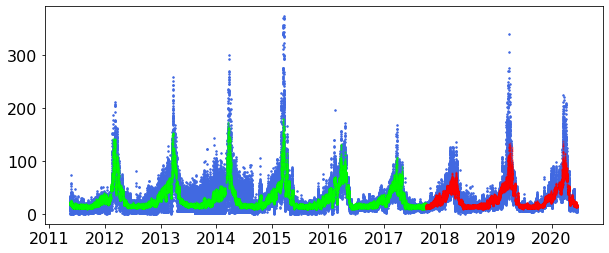

In [14]:
# plot data 
plt.figure(figsize=(10, 4))
plt.plot(data.split_list[0], y_scaler.inverse_transform(ytrn), marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(data.split_list[1], yval, marker='.',linewidth=0,alpha=1, markersize=3,color='royalblue')

ypred = y_scaler.inverse_transform(model.predict(xtrn).reshape(-1,1))

plt.plot(data.split_list[0], ypred, marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='lime')
ypred = y_scaler.inverse_transform(model.predict(xval).reshape(-1,1))
plt.plot(data.split_list[1], ypred, marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')


In [16]:
model = get_nn_model(input_shape=xtrn.shape[1],output_shape=ytrn.shape[1],num_layer=2,nn_size=954,act_fun='softplus',drop=0.06,lr= 0.002,momentum=0.8)
esm = EarlyStopping(patience=8,verbose=0,restore_best_weights=True)
history = model.fit(xtrn, ytrn,validation_split=0.2,verbose=0,epochs=1000,callbacks=[esm])

ypred = model.predict(xval)
ypred = y_scaler.inverse_transform(ypred.reshape(-1,1))
print('test score', cal_scores(yval, ypred, header_str='test_')) 

test score {'test_r2_score': 0.2626072267590085, 'test_mean_squared_error': 576.5906378863693, 'test_mean_absolute_error': 11.402271320631137}


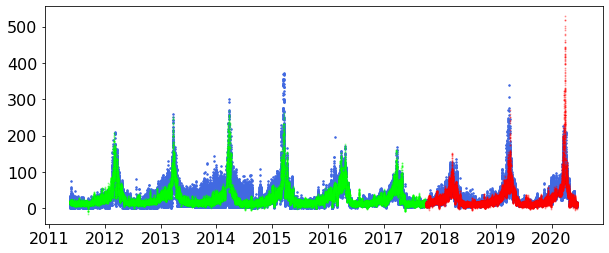

In [17]:
# plot data 
plt.figure(figsize=(10, 4))
plt.plot(data.split_list[0], y_scaler.inverse_transform(ytrn), marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(data.split_list[1], yval, marker='.',linewidth=0,alpha=1, markersize=3,color='royalblue')

ypred = y_scaler.inverse_transform(model.predict(xtrn).reshape(-1,1))

plt.plot(data.split_list[0], ypred, marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='lime')
ypred = y_scaler.inverse_transform(model.predict(xval).reshape(-1,1))
plt.plot(data.split_list[1], ypred, marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')


# Optimize For Diff

In [27]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.fire_dict = {'w_speed': 2, 'shift': -48, 'roll': 26}
data.make_diff_col()
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor ] )
print(x_cols)

data no fire has shape (77746, 15)
use default fire feature
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')


In [28]:
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=x_cols)
ytrn = ytrn.reshape(-1,1)

xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=x_cols)
yval = yval.reshape(-1,1)
data.x_cols = x_cols

min_max_scaler = MinMaxScaler()
xtrn = min_max_scaler.fit_transform(xtrn)
xval = min_max_scaler.transform(xval)

min_max_scaler_y = MinMaxScaler()
ytrn = min_max_scaler_y.fit_transform(ytrn)
yval = min_max_scaler_y.transform(yval)

In [29]:
model = get_model(input_shape=xtrn.shape[1],output_shape=ytrn.shape[1],num_layer=1,nn_size=512,act_fun='relu',drop=0.01,lr=1E-4,momentum=0.99)
esm = EarlyStopping(patience=8,verbose=0,restore_best_weights=True)
history = model.fit(xtrn, ytrn,validation_split=0.2,verbose=1,epochs=100,callbacks=[esm])
   
y_pred = model.predict(xval)
r2_score(yval,y_pred)

Train on 24878 samples, validate on 6220 samples
Epoch 1/100
24878/24878 [==============================] - 4s 167us/step - loss: 0.0580 - val_loss: 0.0159
Epoch 2/100
24878/24878 [==============================] - 3s 127us/step - loss: 0.0176 - val_loss: 0.0322
Epoch 3/100
24878/24878 [==============================] - 3s 131us/step - loss: 0.0146 - val_loss: 0.0232
Epoch 4/100
24878/24878 [==============================] - 4s 158us/step - loss: 0.0126 - val_loss: 0.0129
Epoch 5/100
24878/24878 [==============================] - 3s 120us/step - loss: 0.0115 - val_loss: 0.0130
Epoch 6/100
24878/24878 [==============================] - 3s 129us/step - loss: 0.0102 - val_loss: 0.0195
Epoch 7/100
24878/24878 [==============================] - 4s 157us/step - loss: 0.0093 - val_loss: 0.0132
Epoch 8/100
24878/24878 [==============================] - 3s 121us/step - loss: 0.0085 - val_loss: 0.0105
Epoch 9/100
24878/24878 [==============================] - 3s 122us/step - loss: 0.0075 - val_l

-0.09184113612431832

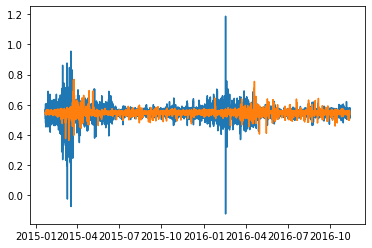

In [30]:
plt.plot(data.split_list[1], yval)
plt.plot(data.split_list[1], y_pred)